In [1]:
UPDATE = "asynchronous"
DIRECTORY = "models/random_nk3"
NUM_RUNS = 100
DEBUG = True

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt

from pyboolnet.external.bnet2primes import bnet_text2primes
from pyboolnet.prime_implicants import percolate
from pyboolnet.file_exchange import primes2bnet
from pyboolnet.state_transition_graphs import primes2stg

from transition_matrix import get_transition_matrix, get_uniform_matrix
from matrix_operations import nsquare, compress_matrix, expand_matrix, get_rms_diff, get_dkl
from grouping import sd_grouping, null_grouping, random_grouping
from basins import get_convergence_matrix, get_basin_ratios
from attractors import get_predicted_attractors


def get_data(bnet, data = {}, update="asynchronous", num_runs=100, DEBUG = False):

    # initialize data
    data["rmsd"] = {}
    data["dkl"] = {}
    
    primes = bnet_text2primes(bnet)
    primes = {key: primes[key] for key in sorted(primes)}
    # Percolate constant nodes and remove them
    percolated_primes = percolate(primes, remove_constants=True, copy=True)
    if len(percolated_primes) == 0:
        return data
    percolated_bnet = primes2bnet(percolated_primes)
    stg = primes2stg(percolated_primes, update)

    T = get_transition_matrix(stg, DEBUG=DEBUG)
    T_inf = nsquare(T, 20, DEBUG=DEBUG)

    sd_indices = sd_grouping(percolated_bnet, DEBUG=DEBUG)
    Tsd = compress_matrix(T, sd_indices, DEBUG=DEBUG)
    Tsd_inf = nsquare(Tsd, 20, DEBUG=DEBUG)
    Tsd_inf_expanded = expand_matrix(Tsd_inf, sd_indices, DEBUG=DEBUG)

    null_indices = null_grouping(percolated_bnet, DEBUG=DEBUG)
    Tnull = compress_matrix(T, null_indices, DEBUG=DEBUG)
    Tnull_inf = nsquare(Tnull, 20, DEBUG=DEBUG)
    Tnull_inf_expanded = expand_matrix(Tnull_inf, null_indices, DEBUG=DEBUG)

    predicted_attractor_indices = get_predicted_attractors(Tsd, sd_indices, as_indices=True, DEBUG=DEBUG)

    # Get convergence matrices
    T_convergence = get_convergence_matrix(T_inf, predicted_attractor_indices, DEBUG=DEBUG)
    Tsd_convergence = get_convergence_matrix(Tsd_inf_expanded, predicted_attractor_indices, DEBUG=DEBUG)
    Tnull_convergence = get_convergence_matrix(Tnull_inf_expanded, predicted_attractor_indices, DEBUG=DEBUG)

    # Get strong basins
    T_basin_ratios = get_basin_ratios(T_convergence, DEBUG=DEBUG)
    Tsd_basin_ratios = get_basin_ratios(Tsd_convergence, DEBUG=DEBUG)
    Tnull_basin_ratios = get_basin_ratios(Tnull_convergence, DEBUG=DEBUG)
    ref_basin_ratios = get_uniform_matrix(1, len(predicted_attractor_indices))

    # Get comparison results
    data["rmsd"]["Tsd"] = get_rms_diff(T_basin_ratios, Tsd_basin_ratios, partial=True, DEBUG=DEBUG)
    data["rmsd"]["Tnull"] = get_rms_diff(T_basin_ratios, Tnull_basin_ratios, partial=True, DEBUG=DEBUG)
    data["rmsd"]["ref"] = get_rms_diff(T_basin_ratios, ref_basin_ratios, partial=True, DEBUG=DEBUG)

    data["dkl"]["Tsd"] = get_dkl(T_basin_ratios, Tsd_basin_ratios, partial=True, DEBUG=DEBUG)
    data["dkl"]["Tnull"] = get_dkl(T_basin_ratios, Tnull_basin_ratios, partial=True, DEBUG=DEBUG)
    data["dkl"]["ref"] = get_dkl(T_basin_ratios, ref_basin_ratios, partial=True, DEBUG=DEBUG)
    
    # Get basin ratios for the random matrix and get comparison results
    data["rmsd"]["Trandom"] = []
    data["dkl"]["Trandom"] = []
    for i in range(num_runs):
        random_indices = random_grouping(sd_indices, null_indices, seed=i, DEBUG=DEBUG)
        Trandom = compress_matrix(T, random_indices, DEBUG=DEBUG)
        Trandom_inf = nsquare(Trandom, 20, DEBUG=DEBUG)
        Trandom_inf_expanded = expand_matrix(Trandom_inf, random_indices, DEBUG=DEBUG)

        Trandom_convergence = get_convergence_matrix(Trandom_inf_expanded, predicted_attractor_indices, DEBUG=DEBUG)
        Trandom_basin_ratios = get_basin_ratios(Trandom_convergence, DEBUG=DEBUG)

        data["rmsd"]["Trandom"].append(get_rms_diff(T_basin_ratios, Trandom_basin_ratios, partial=True, DEBUG=DEBUG))
        data["dkl"]["Trandom"].append(get_dkl(T_basin_ratios, Trandom_basin_ratios, partial=True, DEBUG=DEBUG))
    
    return data

In [3]:
all_data = {}

# Iterate over the files in the directory
for filename in sorted(os.listdir(DIRECTORY)):

    file_path = os.path.join(DIRECTORY, filename)
    
    # Check if it's a file (not a directory)
    if not os.path.isfile(file_path):
        continue

    # Open and read the file
    with open(file_path, 'r') as file:
        print(f"Reading file: {filename}")
        content = file.read()
        
    data = get_data(bnet=content, data={}, update=UPDATE, num_runs=NUM_RUNS, DEBUG=DEBUG)

    all_data[filename] = data

Reading file: n010_000.bnet
Reading file: n010_001.bnet
Reading file: n010_002.bnet
Reading file: n010_003.bnet
Reading file: n010_004.bnet
duplicates={'000000001': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n2': 0, 'n6': 0, 'n8': 0}]], '000000101': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000000111': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000010001': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n2': 0, 'n6': 0, 'n8': 0}]], '000010100': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000010101': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000010110': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000010111': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000100001': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n2': 0, 'n6': 0, 'n8': 0}]], '000100100': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], 

In [4]:
for bnet in all_data:
    if len(all_data[bnet]["rmsd"]) == 0:
        print(bnet)
        continue
    print(bnet,
          all_data[bnet]["rmsd"]["Tsd"],
          np.mean(all_data[bnet]["rmsd"]["Trandom"]),
          all_data[bnet]["rmsd"]["Tnull"],
          all_data[bnet]["rmsd"]["ref"],

          all_data[bnet]["dkl"]["Tsd"],
          np.mean(all_data[bnet]["dkl"]["Trandom"]),
          all_data[bnet]["dkl"]["Tnull"],
          all_data[bnet]["dkl"]["ref"]
          )

n010_000.bnet 0.01568697158060496 0.29908863101980404 0.2991985580333666 0.2991985580333666 0.0007385943724255231 0.191514365193211 0.19163572775249968 0.19163572775249968
n010_001.bnet 0.025674494883054663 0.07786397954963242 0.07938224485746867 0.04544699866327808 0.008841299054521051 0.06698149101566343 0.06773281688271263 0.026206781139997023
n010_002.bnet 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
n010_003.bnet 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
n010_004.bnet 0.03444428065804177 0.11096856212719546 0.11216193151186163 0.12408776605129096 0.009473712094019229 0.13418313692036138 0.13620435098690525 0.15877550770257204
n010_005.bnet 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
n010_006.bnet 0.04945219357429215 0.11600706674414331 0.11712926440262209 0.11712926440262209 0.005036830533287989 0.027379680687904803 0.027695163206216705 0.027695163206216705
n010_007.bnet 0.017072399360886753 0.012828468270517224 0.012463314320619895 0.07471917369561998 0.0005924819324031848 0.0005407065459339474 0.00031625935931493

In [5]:
def plot_rmsd_and_dkl(rmsd, dkl):

    # Create histograms of precision and recall
    plt.figure(figsize=(10, 6))

    # Plotting the histogram for Precision
    plt.subplot(1, 2, 1)
    plt.hist(rmsd, bins=10, color='blue', alpha=0.7)
    plt.title('RMSD Histogram')
    plt.xlabel('RMSD')
    plt.ylabel('Frequency')
    plt.xlim(0, 1)
    plt.ylim(0, 50)

    # Plotting the histogram for Recall
    plt.subplot(1, 2, 2)
    plt.hist(dkl, bins=10, color='green', alpha=0.7)
    plt.title('Dkl Histogram')
    plt.xlabel('normalized Dkl')
    plt.ylabel('Frequency')
    plt.xlim(0, 30)
    plt.ylim(0, 50)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

0.027221630957969128 0.06221688688469243
2.113654768212424 6.355155677677977


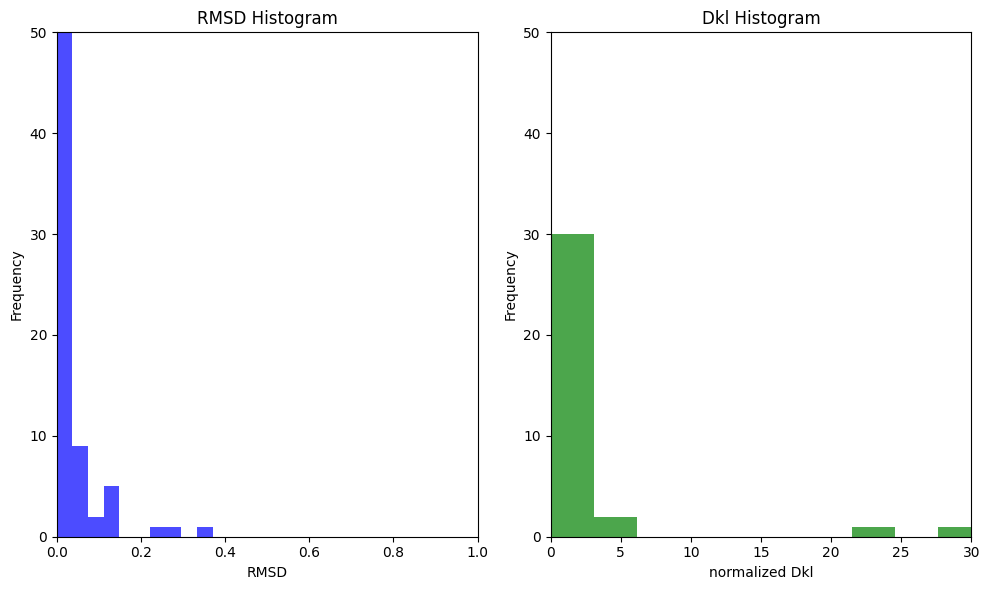

In [6]:
rmsd = []
dkl = []
for bnet in all_data:
    if len(all_data[bnet]["rmsd"]) == 0:
        continue
    rmsd.append(all_data[bnet]["rmsd"]["Tsd"])
    if all_data[bnet]["dkl"]["ref"] != 0:
        dkl.append(all_data[bnet]["dkl"]["Tsd"] / all_data[bnet]["dkl"]["ref"])

print(np.mean(rmsd), np.std(rmsd))
print(np.mean(dkl), np.std(dkl))

plot_rmsd_and_dkl(rmsd, dkl)